In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
folder = 'data_yang_dipake/'

In [3]:
df = pd.read_csv(f'{folder}dataML.csv')

In [4]:
df.head()

,Unnamed: 0,full_text,Label
0,0,@Iam_Nobody_1145 Sama aja dong kek kasus kudat...,2.0
1,1,@Bambangmulyonoo @PDI_Perjuangan Salah satu ya...,2.0
2,2,@Miduk17 @agussusilo7562 @ganjarpranowo @mohma...,2.0
3,3,@Paltiwest Pdi p jgn mw menampung mental2 pngk...,2.0
4,4,@Minietweets_ @adri_7i @adi_sareang @alextham8...,0.0


In [5]:
df = df.drop(columns='Unnamed: 0')

In [6]:
df['full_text'] = df['full_text'].astype(str)

In [7]:
df = df.dropna()

In [8]:
df['Label'] = df['Label'].astype(int)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3430 entries, 0 to 3432
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  3430 non-null   object
 1   Label      3430 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 67.0+ KB


In [10]:
label_map = {0: 'Positive', 1: 'Toxic', 2: 'Critique', 3: 'Others'}

In [11]:
df['sentiment'] = df['Label'].replace(label_map)

In [12]:
import re

# Translate emoticon
emoticon_data_path = 'external/emoticon.txt'
emoticon_df = pd.read_csv(emoticon_data_path, sep='\t', header=None)
emoticon_dict = dict(zip(emoticon_df[0], emoticon_df[1]))

def translate_emoticon(t):
    for w, v in emoticon_dict.items():
        pattern = re.compile(re.escape(w))
        match = re.search(pattern,t)
        if match:
            t = re.sub(pattern,v,t)
    return t

In [13]:
def remove_newline(text):
    return re.sub('\n', ' ',text)

In [14]:
def remove_url(text):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)

In [15]:
def remove_excessive_whitespace(text):
    return re.sub('  +', ' ', text)

In [16]:
from nltk.tokenize import WordPunctTokenizer

def tokenize_text(text, punct=False):
    text = WordPunctTokenizer().tokenize(text)
    text = [word for word in text if punct or word.isalnum()]
    text = ' '.join(text)
    text = text.strip()
    return text

In [17]:
slang_words = pd.read_csv('external/slangword.csv')
slang_dict = dict(zip(slang_words['original'],slang_words['translated']))

def transform_slang_words(text):
    word_list = text.split()
    word_list_len = len(word_list)
    transformed_word_list = []
    i = 0
    while i < word_list_len:
        if (i + 1) < word_list_len:
            two_words = ' '.join(word_list[i:i+2])
            if two_words in slang_dict:
                transformed_word_list.append(slang_dict[two_words])
                i += 2
                continue
        transformed_word_list.append(slang_dict.get(word_list[i], word_list[i]))
        i += 1
    return ' '.join(transformed_word_list)

In [18]:
def remove_non_alphabet(text):
    output = re.sub('[^a-zA-Z ]+', '', text)
    return output

In [19]:
def remove_twitter_formatting(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'\brt\b', '', text)
    return text

In [20]:
import itertools

def remove_repeating_characters(text):
    return ''.join(''.join(s)[:1] for _, s in itertools.groupby(text))

In [21]:
def preprocess_text(text):
    transformed_text = text.lower()
    transformed_text = remove_newline(text)
    transformed_text = remove_url(transformed_text)
    transformed_text = remove_twitter_formatting(transformed_text)
    transformed_text = translate_emoticon(transformed_text)
    transformed_text = transformed_text.lower()
    transformed_text = tokenize_text(transformed_text)
    transformed_text = transform_slang_words(transformed_text)
    transformed_text = remove_repeating_characters(transformed_text)
    transformed_text = transform_slang_words(transformed_text)
    transformed_text = remove_non_alphabet(transformed_text)
    transformed_text = remove_excessive_whitespace(transformed_text)
    transformed_text = transformed_text.lower().strip()
    return transformed_text

In [22]:
df['preprocessed'] = df['full_text'].apply(preprocess_text)

In [23]:
df.head()

,full_text,Label,sentiment,preprocessed
0,@Iam_Nobody_1145 Sama aja dong kek kasus kudat...,2,Critique,sama saja dong seperti kasus kudatuli yang tid...
1,@Bambangmulyonoo @PDI_Perjuangan Salah satu ya...,2,Critique,salah satu yang kencang teriak periode buzer p...
2,@Miduk17 @agussusilo7562 @ganjarpranowo @mohma...,2,Critique,tapi pdi tidak berani atau jadi penghalang yah
3,@Paltiwest Pdi p jgn mw menampung mental2 pngk...,2,Critique,pdi p jangan mau menampung mental pngkhianat j...
4,@Minietweets_ @adri_7i @adi_sareang @alextham8...,0,Positive,pdip deh pdi kan sudah biasa dibeginikan bahka...


In [24]:
df['sentiment'].value_counts()

sentiment
Toxic       1303
Others       950
Positive     834
Critique     343
Name: count, dtype: int64

In [25]:
from nltk.tokenize import word_tokenize

def tokenise(text):
    words = word_tokenize(text) 
    return words

In [26]:
df['tokenized'] = df['preprocessed'].apply(tokenise)

In [27]:
top = Counter([item for sublist in df['tokenized'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,yang,1732
1,di,1714
2,kamu,1365
3,tidak,1135
4,rt,1125
5,dan,910
6,kontol,785
7,kafir,765
8,orang,718
9,memek,696


In [28]:
Positive_sent = df[df['Label']==0]
Toxic_sent = df[df['Label']==1]
Critique_sent = df[df['Label']==2]
Others_sent = df[df['Label']==3]

In [29]:
print('Number of tweets with Positive sentiment', Positive_sent['Label'].count())
print('Number of tweets with Toxic sentiment', Toxic_sent['Label'].count())
print('Number of tweets with Critique sentiment', Critique_sent['Label'].count())
print('Number of tweets with Others sentiment', Others_sent['Label'].count())

Number of tweets with Positive sentiment 834
Number of tweets with Toxic sentiment 1303
Number of tweets with Critique sentiment 343
Number of tweets with Others sentiment 950


In [30]:
top = Counter([item for sublist in Positive_sent['tokenized'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,yang,490
1,di,391
2,tidak,310
3,dan,284
4,papua,227
5,khilafah,186
6,itu,185
7,indonesia,183
8,rt,176
9,dari,162


In [31]:
top = Counter([item for sublist in Toxic_sent['tokenized'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,kamu,759
2,yang,652
3,rt,526
4,kafir,495
5,tidak,456
6,orang,435
7,papua,325
8,dan,311
9,seperti,305
10,agama,294


In [32]:
top = Counter([item for sublist in Critique_sent['tokenized'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='YlOrRd')

,Common_words,count
1,di,185
2,tidak,156
3,dan,142
4,kafir,120
5,itu,116
6,khilafah,95
7,kalau,92
8,orang,92
9,papua,90
10,saja,88


In [33]:
top = Counter([item for sublist in Others_sent['tokenized'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='GnBu')

,Common_words,count
1,kontol,508
2,kamu,463
3,aku,409
4,rt,363
5,di,339
6,yang,313
7,remas,298
8,tetek,241
9,tidak,213
10,susu,194


In [34]:
X,y = df['preprocessed'].values,df['sentiment'].values

In [35]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (2572,)
shape of test data is (858,)


C:\Users\Ilham AM\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


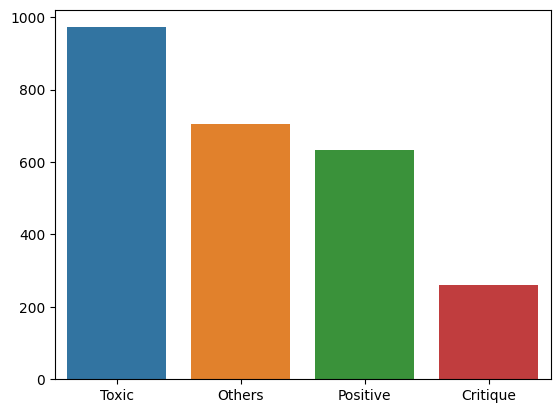

In [37]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=['Toxic', 'Others', 'Positive', 'Critique'],y=dd.values)
plt.show()

In [38]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import classification_report

In [39]:
max_words = 5000  # Jumlah kata unik yang akan diikutsertakan dalam Tokenizer
max_len = 200     # Panjang maksimum dari sebuah sequence (dapat disesuaikan)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

In [40]:
X_train_sequences = tokenizer.texts_to_sequences(x_train)
X_test_sequences = tokenizer.texts_to_sequences(x_test)

In [41]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

In [42]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, dropout=0.2))
model.add(Dense(5, activation='softmax'))

In [43]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 689,733
Trainable params: 689,733
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
65/65 [==============================] - 8s 92ms/step - loss: 1.2379 - accuracy: 0.4895 - val_loss: 0.9182 - val_accuracy: 0.6175
Epoch 2/10
65/65 [==============================] - 6s 85ms/step - loss: 0.8185 - accuracy: 0.6743 - val_loss: 0.8061 - val_accuracy: 0.6738
Epoch 3/10
65/65 [==============================] - 4s 65ms/step - loss: 0.6147 - accuracy: 0.7632 - val_loss: 0.8024 - val_accuracy: 0.6816
Epoch 4/10
65/65 [==============================] - 4s 67ms/step - loss: 0.4196 - accuracy: 0.8493 - val_loss: 0.8890 - val_accuracy: 0.6408
Epoch 5/10
65/65 [==============================] - 4s 65ms/step - loss: 0.2861 - accuracy: 0.9018 - val_loss: 1.0542 - val_accuracy: 0.6447
Epoch 6/10
65/65 [==============================] - 5s 71ms/step - loss: 0.2010 - accuracy: 0.9339 - val_loss: 1.0912 - val_accuracy: 0.6330
Epoch 7/10
65/65 [==============================] - 4s 65ms/step - loss: 0.1542 - accuracy: 0.9460 - val_loss: 1.1446 - val_accuracy: 0.6252
Epoch 8/10
65

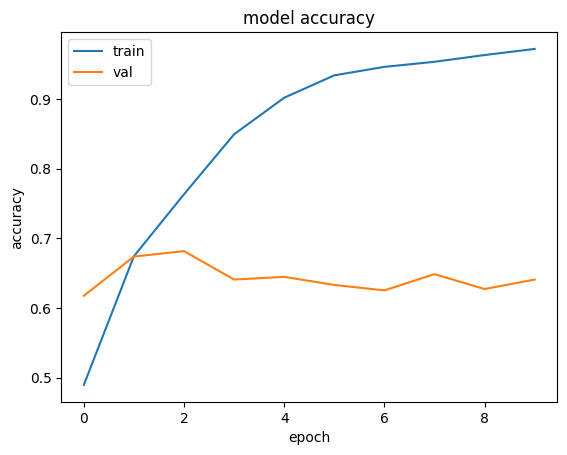

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

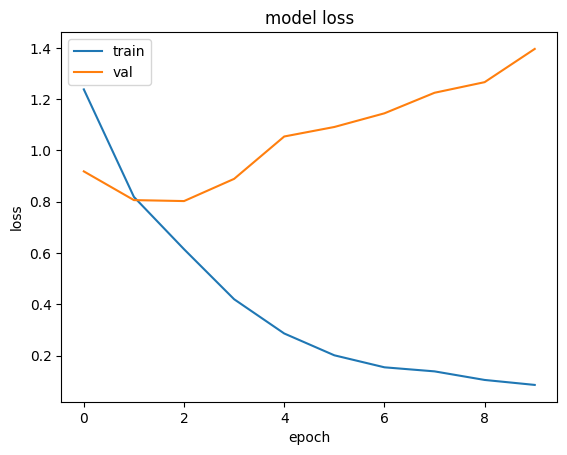

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
y_pred_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

27/27 [==============================] - 1s 18ms/step


In [48]:
y_pred_labels = label_encoder.inverse_transform(y_pred)

In [49]:
results_df = pd.DataFrame({'Text': x_test, 'True Label': label_encoder.inverse_transform(y_test), 'Predicted Label': y_pred_labels})

In [50]:
results_df

,Text,True Label,Predicted Label
0,foto memek sempit anak sampai gadis perawan fo...,Others,Others
1,heh kontol jan sok pemes kamu di rp muka seper...,Toxic,Toxic
2,foto memek abg sama mesum terbaru foto memek a...,Others,Others
3,pak ahok kalau anda jadi gubernur jangan lupa ...,Positive,Toxic
4,bahan coli seksi bispak birahi tetek puting ji...,Others,Others
...,...,...,...
853,abang mereka investor kan kafir jadi harus di ...,Toxic,Critique
854,anies baswedan tidak mengatakan masalah konfli...,Positive,Toxic
855,mainin jari di v line sepong kenceng kontol ka...,Others,Others
856,amin rt sama dengan papua kalau warga sumatera...,Positive,Positive


In [51]:
print(classification_report(y_pred_labels, label_encoder.inverse_transform(y_test)))

              precision    recall  f1-score   support

    Critique       0.16      0.25      0.19        53
      Others       0.79      0.85      0.82       226
    Positive       0.45      0.55      0.49       164
       Toxic       0.76      0.61      0.68       415

    accuracy                           0.64       858
   macro avg       0.54      0.56      0.55       858
weighted avg       0.67      0.64      0.65       858



In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred_labels, label_encoder.inverse_transform(y_test))
cm

array([[ 13,   3,  17,  20],
       [  2, 193,  13,  18],
       [ 23,  10,  90,  41],
       [ 44,  38,  81, 252]], dtype=int64)

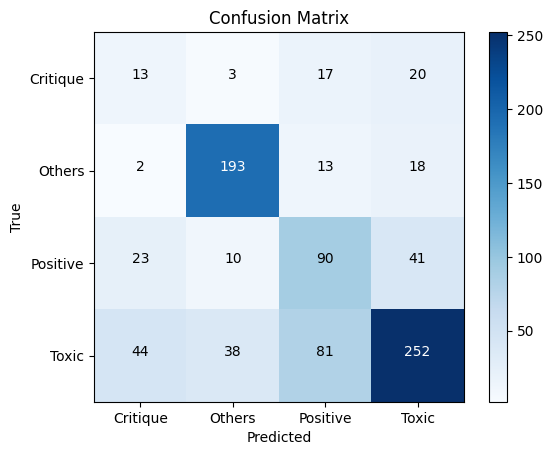

In [53]:
import matplotlib.pyplot as plt 
import numpy as np

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.yticks(tick_marks, ['Critique', 'Others', 'Positive', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")